# Table of Contents

   * [Data Collection](#DC)
   * [Data Cleaning](#DCL)
   * [Summarize Self Text](#SST)
   * [Sentiment Analysis](#SA)
   * [Cvec on MNB Model with Sentiment Analysis](#CVMBS)
   * [Tf-Idf on MNB Model with Sentiment Analysis](#TFMBS)
   * [Cvec on MNB Model](#CVMB)
   * [Tf-Idf on MNB Model](#TFMB)
   * [Tf-Idf on Logistic Regression Model](#TFLOG)
   * [Tf-Idf on Random Forest](#TFRF)
   * [Tf-Idf on Decision Tree](#TFDT)
   * [Tf-Idf on SVM](#TFSVM)

In [1]:
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import praw
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

pd.set_option('display.max_colwidth', None)

## DATA COLLECTION <a class="anchor" id="DC"></a>

In [2]:
# Shout out to thomaz for telling me about this API, much better than pushshift
# uses PRAW (Python Reddit API Wrapper)

user_agent = 'Scraper 1 by ken'
reddit = praw.Reddit(
    client_id = 'QrCPchQTYLF9ZPC4arCAPg',
    client_secret = 'A4y7OySKS_2aUY4FnmWlkgHFiZA56Q',
    user_agent = user_agent
)

In [3]:
# Creating the df from the askmen subreddit
ask_men = []
for submission in reddit.subreddit('askmen').top('year', limit = 1000):
    data = {}
    data['title'] = submission.title
    data['subreddit'] = submission.subreddit
    data['selftext'] = submission.selftext
    ask_men.append(data)

askmen_df = pd.DataFrame(ask_men)
askmen_df.head()

,title,subreddit,selftext
0,"Contrary to popular belief about guys, the single men I know keep their homes exceptionally clean. What male stereotypes don’t apply to you?",AskMen,
1,"As an introvert, how do you feel about this quote by Jim Carrey? “Solitude is dangerous. It’s very addictive. It becomes a habit after you realize how calm and peaceful it is. It’s like you don’t want to deal with people anymore because they drain your energy.”",AskMen,Edit: Wow I did not expect this to this well! \nDisclaimer: This post was first made in r/askwoman. I brought it over here to show more people. If you upvoted this upvote the main one: https://www.reddit.com/r/AskWomen/comments/9fu95q/as_an_introvert_how_do_you_feel_about_this_quote/
2,What did you not know or realize until after living with a woman?,AskMen,"For example, I had no idea that you weren’t supposed to wash your hair everyday until after my girlfriend moved in."
3,"Men of Reddit, how often have do/do you change your walk because you’re walking behind a woman late at night?",AskMen,"This question is influenced by a video I saw where a guy explained that he was unintentionally the “creepy guy” because he was walking behind a woman in a park. As a woman it honestly never occurred to me that innocent men can be deemed as creepy just because they just so happen to be walking the same direction. Is this something you guys naturally take into consideration when walking?\n\nEdit: WOW I was not expecting this much of a response\n\nEdit: Thanks to u/Ok-Brother-2337 for sending me such a lovely message calling me a dumb, unattractive, attention seeker for just asking an innocent question."
4,How can you work a 9 to 5 Job with only the Weekends and 4 weeks per year Off without getting the feeling of waisting your life?,AskMen,I(16m) have been looking what i could do after graduating school and realised that this all is shit how can somebody be ok with Working a 9 to 5 Job sitting in a Office Coming home just to do this pointless shit the next morning again. Always do what your Boss says only having the Weekends and 4 weeks per year Off and wasting your life doing the same shit over and over again. I mean thats One of the most depressing things i've ever heard of \n\nSorry for errors english isnt my Standart language


In [4]:
#creating the df from the askwomen subreddit
ask_women = []
for submission in reddit.subreddit('askwomen').top('year', limit = 1000):
    data = {}
    data['title'] = submission.title
    data['subreddit'] = submission.subreddit
    data['selftext'] = submission.selftext
    ask_women.append(data)

askwomen_df = pd.DataFrame(ask_women)
askwomen_df.head()

,title,subreddit,selftext
0,"When Kamala Harris said ‘I am speaking’ while she was being interrupted over and over, how did that resonate with you?",AskWomen,"Sorry guys - this post has gotten traction because it resonated with a lot of people but the mods have locked it indefinitely. \n\nI posted this question to understand what a moment felt for many women after I saw my own sister wince. It’s small question but the response has been powerful. I feel a lot of people can be heard and a lot of people like myself can learn. \n\nHopefully if they open this sooner rather than later, we can hear more experiences and comments geared towards the question in hand. I am not sure exactly why this question in particular has been locked for this long.\n\nEdit 2: it’s been a month and it’s looking like this post was locked because of its content as opposed to clearing out any comments as the mods have suggested. Wonder if they had an issue with the question or the Kamala Harris?"
1,"""Men apply for a job when they meet only 60% of the qualifications, but women apply only if they meet 100% of them."" - What are your thoughts on this?",AskWomen,Source: [https://hbr.org/2014/08/why-women-dont-apply-for-jobs-unless-theyre-100-qualified](https://hbr.org/2014/08/why-women-dont-apply-for-jobs-unless-theyre-100-qualified) \n\nI feel like the impostor syndrome women feel is real!
2,"For those of you down to your last hair tie, how long has it been since you noticed and have started treasuring it like a very rare diamond?",AskWomen,"Edit: the number of you brilliant people who have replied with some form of ""my precious"" is my new favourite thing.\n\nGod love you all.\n\nEdit 2: A very large number of you have cats who eat your hair ties. I'm not a pet owner but please, please look after your fur babies. This doesn't sound healthy for them.\n\nEdit 3: I can't keep up with the replies to this any more. I hope all of you who read this have a lovely day."
3,"If you had a friend who spoke to you in the same way you sometimes speak to yourself, how long would you allow this person to be your friend?",AskWomen,
4,What was your reaction when you heard about the Norway women's handball team being fined and threatened with disqualification for wanting to wear shorts instead of bikini bottoms?,AskWomen,


In [5]:
#creating one big df
df = askmen_df.append(askwomen_df)

## DATA CLEANING <a class="anchor" id="CL"></a>

In [6]:
# changing the target variable 
df['subreddit'] = [0 if sub == 'AskMen' else 1 for sub in df['subreddit']]

In [7]:
#checking for null values
df.isna().sum()

title        0
subreddit    0
selftext     0
dtype: int64

In [8]:
# creating one column of text so we can feed it into count vec
df['text'] = df['title'] + df['selftext']

In [9]:
# resetting index so we can do sentiment analysis
df.reset_index(inplace = True)

In [10]:
# #import nltk language cleaning, imported all of these to make a function to clean text, spent too long on it, but then countvect and tfdf just do it automatically...
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer

In [11]:
# # function that returns cleaned text, stopwords removed, unnecessary punctuation removed, text lowered
# def text_cleaner(text):
#     snowball = SnowballStemmer(language = 'english')
#     text = text.apply(word_tokenize)
#     stop_words = stopwords.words('english')
#     new_stop = ['?', "'", 'guys', 'girls', 'women', 'men', 'male', 'female', 'girl', ',', '.']
#     stop_words = stop_words + new_stop
#     clean_text = []
#     for t in text:
#         t = [snowball.stem(w.lower()) for w in t if not w.lower() in stop_words]
#         clean_text.append(t)
#     cleaned = {'a':clean_text}
#     return pd.DataFrame(cleaned)

In [12]:
# # cleaning text
# df_3['title'] = text_cleaner(df_3['title'])
# df_3['selftext'] = text_cleaner(df_3['selftext'])

## Summarize SelfText <a class="anchor" id="SST"></a>

In [13]:
# So I was going to use summarize on the selftext and then run a sentiment analysis, but the summarize text took way too long to run on my model so I decided to leave this out
# summarize = pipeline('summarization')

In [14]:
# df['selftext'] = df['selftext'].apply(summarize())

## Sentiment Analysis <a class="anchor" id="SA"></a>

In [15]:
# here we will add a sentiment analysis to see if the posts on either subreddit are more negative or positive
# so I ran sentiment analysis on just the titles, but it didn't turn out to be as helpful as I thought. Firstly, the distribution of negative vs positive titles was roughly the same across the subreddits. But the main problem was the the sentiment
# analysis was not analyzing the questions properly. For example, it rated the question "what makes you feel feminine" as highly negative which is definitely not true and as I looked through the examples there were more and more like that.
# I believe the problem is that question aren't inherently positive or negative and can be quite neutral, therefore the sentiment analysis doesn't really work on them. It does slight make my scores better, but hard to say definitively that it helped.
from transformers import pipeline
sent = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [16]:
# creating new column with analysis of sentiment
df['sent'] = df['title'].apply(sent)

In [17]:
# creating a list of all the sentiment data so we can put it into a data frame
sent_list = []
for i, v in enumerate(df['sent']):
    sent_list.append(v[0])

In [18]:
# creating sentiment data frame
sent_df = pd.DataFrame(sent_list)
sent_df

,label,score
0,POSITIVE,0.982284
1,NEGATIVE,0.914297
2,NEGATIVE,0.980875
3,NEGATIVE,0.991641
4,NEGATIVE,0.997510
...,...,...
1991,NEGATIVE,0.993568
1992,POSITIVE,0.997628
1993,NEGATIVE,0.989111
1994,POSITIVE,0.996736


In [19]:
# changing the label column to 1 and 0
sent_df['label'] = sent_df['label'].map({'POSITIVE': 1, 'NEGATIVE': 0})

In [77]:
# combining the data frames
df = pd.concat([df, sent_df], axis =1)


In [21]:
# looking at percentage negative vs positive for men
df.loc[df['subreddit']==0]['label'].value_counts(normalize = True)

0    0.790791
1    0.209209
Name: label, dtype: float64

In [22]:
# looking at percentage negative vs positive for women
df.loc[df['subreddit']==1]['label'].value_counts(normalize = True)

0    0.746239
1    0.253761
Name: label, dtype: float64

In [23]:
# Function to plot confusion matrix and roc curve

def cm_roc (model, X_test, y_test):


    plot_confusion_matrix(model, X_test, y_test, cmap = "Blues");

    # ROC curve
    plot_roc_curve(model, X_test, y_test)
    # add worst case scenario line
    plt.plot([0,1], [0,1],
            label = 'baseline', linestyle = '--')

    # add a legend
    plt.legend()

## Count Vectorizer Transform (With Sentiment) With MNB Model <a class="anchor" id="CVMBS"></a>

In [78]:
#setting up our data
X = df[['text', 'score', 'label']]
y = df['subreddit']

In [25]:
#doing a train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [26]:
ct = ColumnTransformer([
    ## (name, transformer, column(s))
    ## transformer can also be "passthrough" (to pass columns untransformed), or "drop" (to drop columns)
    ('cvec', CountVectorizer(), 'text'),
    ('pass', 'passthrough', ['score', 'label'])
])

In [27]:
# setting up our pipe


pipe_ct_cv_mb = Pipeline([
    ('ct', ct),
    ('mnb', MultinomialNB())
])

In [28]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipectcvmb_params = {
    'ct__cvec__max_features': [2000,3000,4000,5000, None],
    'ct__cvec__min_df':[2, 3],
    'ct__cvec__max_df':[0.9, 0.95],
    'ct__cvec__ngram_range':[(1,1), (1,2)],
    'ct__cvec__stop_words':[None, 'english']
}

In [29]:
# setting up our gridsearch
gs_ct_cv_mb = GridSearchCV(estimator = pipe_ct_cv_mb, # what object are we optimizing?
                  param_grid = pipectcvmb_params, # what parameters values are we searching?
                  cv = 5,
                  verbose = 1) # 5-fold cross-validation.

In [30]:
# Fit GridSearch to training data.
gs_ct_cv_mb.fit(X_train, y_train)

# training score
print(f'Training Score: {gs_ct_cv_mb.score(X_train, y_train)}')

# testing score
print(f'Testing Score: {gs_ct_cv_mb.score(X_test, y_test)}')

# best score
print(f'Best Score: {gs_ct_cv_mb.best_score_}')

# best params
print(f'Best Params: {gs_ct_cv_mb.best_params_}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Training Score: 0.8309648466716529
Testing Score: 0.7556904400606981
Best Score: 0.7741405332886131
Best Params: {'ct__cvec__max_df': 0.9, 'ct__cvec__max_features': 4000, 'ct__cvec__min_df': 2, 'ct__cvec__ngram_range': (1, 2), 'ct__cvec__stop_words': None}


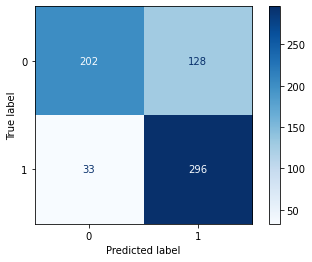

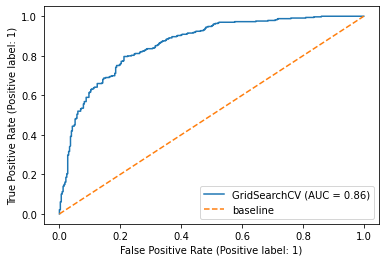

In [31]:
cm_roc(gs_ct_cv_mb, X_test, y_test)

## CVEC with MNB <a class="anchor" id="CVMB"></a>

In [32]:
X = df['text']
y = df['subreddit']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [34]:
pipe_cv_mb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [35]:
pipecvmb_params = {
    'cvec__max_features': [2000,3000,4000,5000, None],
    'cvec__min_df':[2, 3],
    'cvec__max_df':[0.9, 0.95],
    'cvec__ngram_range':[(1,1), (1,2)],
    'cvec__stop_words':[None, 'english']
}

In [36]:
# setting up our gridsearch
gs_cv_mb = GridSearchCV(estimator = pipe_cv_mb, # what object are we optimizing?
                  param_grid = pipecvmb_params, # what parameters values are we searching?
                  cv = 5,
                  verbose = 1) # 5-fold cross-validation.

In [37]:
gs_cv_mb.fit(X_train, y_train)

# training score
print(f'Training Score: {gs_cv_mb.score(X_train, y_train)}')

# testing score
print(f'Testing Score: {gs_cv_mb.score(X_test, y_test)}')

# best score
print(f'Best Score: {gs_cv_mb.best_score_}')

# best params
print(f'Best Params: {gs_cv_mb.best_params_}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Training Score: 0.8399401645474944
Testing Score: 0.7632776934749621
Best Score: 0.7786349153110851
Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}


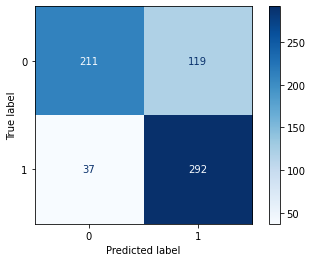

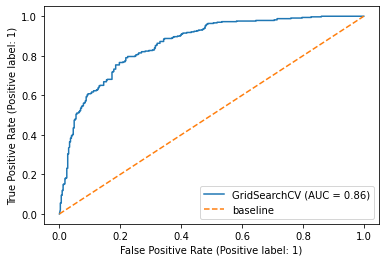

In [38]:
cm_roc(gs_cv_mb, X_test, y_test)

## Tiffy Diff Transformer (With Sentiment) with MNB Model <a class="anchor" id="TFMBS"></a>

In [39]:
#setting up our data
X = df[['text', 'score', 'label']]
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [40]:
ct = ColumnTransformer([
    ## (name, transformer, column(s))
    ## transformer can also be "passthrough" (to pass columns untransformed), or "drop" (to drop columns)
    ('tvec', TfidfVectorizer(), 'text'),
    ('pass', 'passthrough', ['score', 'label'])
])

In [41]:
pipe_ct_tv_mb = Pipeline([
    ('ct', ct),
    ('mnb', MultinomialNB())
])

In [42]:
pipecttvmb_params = {
    'ct__tvec__max_features': [2000, 3000, 4000, 5000, None],
    'ct__tvec__stop_words':[None, 'english'],
    'ct__tvec__ngram_range':[(1,1), (1,2), (1,3)],
    'ct__tvec__min_df': [1, 2, 3, 4, 5]
}

In [43]:
gs_ct_tv_mb = GridSearchCV(estimator = pipe_ct_tv_mb, # what object are we optimizing?
                  param_grid = pipecttvmb_params, # what parameters values are we searching?
                  cv = 5,
                  verbose = 1) # 5-fold cross-validation.

In [44]:
# Fit GridSearch to training data.
gs_ct_tv_mb.fit(X_train, y_train)

# training score
print(f'Training Score: {gs_ct_tv_mb.score(X_train, y_train)}')

# testing score
print(f'Testing Score: {gs_ct_tv_mb.score(X_test, y_test)}')

# best score
print(f'Best Score: {gs_ct_tv_mb.best_score_}')

# best params
print(f'Best Params: {gs_ct_tv_mb.best_params_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Training Score: 0.9094988780852655
Testing Score: 0.7890743550834598
Best Score: 0.7898568952987871
Best Params: {'ct__tvec__max_features': 5000, 'ct__tvec__min_df': 2, 'ct__tvec__ngram_range': (1, 3), 'ct__tvec__stop_words': None}


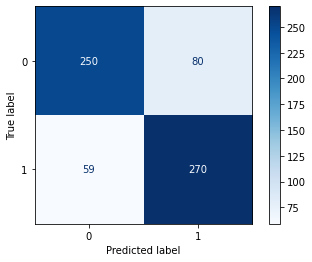

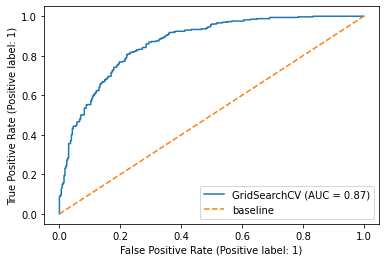

In [45]:
cm_roc(gs_ct_tv_mb, X_test, y_test)

## Tiffy Diff Transformer with MNB Model <a class="anchor" id="TFMB"></a>

In [46]:
# setting up our training and testing data
#setting up our data
X = df['text']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [47]:
#making tvec pipe
tvec_mb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [48]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipetfmb_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000, None],
    'tvec__stop_words':[None, 'english'],
    'tvec__ngram_range':[(1,1), (1,2), (1,3)],
    'tvec__min_df': [1, 2, 3, 4, 5]
}

In [49]:
# Instantiate GridSearchCV.
gs_tv_mb = GridSearchCV(tvec_mb_pipe, param_grid = pipetfmb_params, cv = 5,
                      verbose = 2, n_jobs = 8)

In [50]:
# Fit GridSearch to training data.
gs_tv_mb.fit(X_train, y_train)

print(f'Training Score: {gs_tv_mb.score(X_train, y_train)}')

# testing score
print(f'Testing Score: {gs_tv_mb.score(X_test, y_test)}')

# best score
print(f'Best Score: {gs_tv_mb.best_score_}')

# best params
print(f'Best Params: {gs_tv_mb.best_params_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Training Score: 0.9050112191473448
Testing Score: 0.7905918057663126
Best Score: 0.7980938006596232
Best Params: {'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


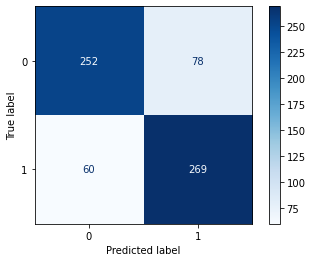

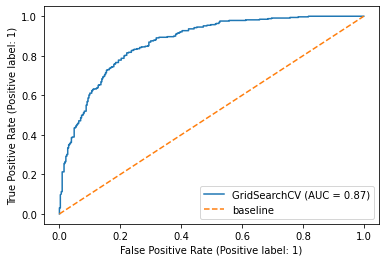

In [51]:
cm_roc(gs_tv_mb, X_test, y_test)

## Count Vec with KNN <a class="anchor" id="CVKN"></a>

In [52]:
# setting up traintest split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [53]:
# setting up neighbors pipe
pipe_cv_kn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [54]:
# setting up cvec knn params
pipecvkn_params = {
    'cvec__max_features': [2000,3000,4000,5000, None],
    'cvec__min_df':[2, 3],
    'cvec__max_df':[0.9, 0.95],
    'cvec__ngram_range':[(1,1), (1,2)],
    "knn__n_neighbors" : [10, 20, 30],
    "knn__weights" : ['uniform', 'distance']
}

In [55]:
gs_cv_kn = GridSearchCV(pipe_cv_kn, # What is the model we want to fit?
                                 pipecvkn_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1)

In [56]:
gs_cv_kn.fit(X_train, y_train)

print(f'Training Score: {gs_cv_kn.score(X_train, y_train)}')

# testing score
print(f'Testing Score: {gs_cv_kn.score(X_test, y_test)}')

# best score
print(f'Best Score: {gs_cv_kn.best_score_}')

# best params
print(f'Best Params: {gs_cv_kn.best_params_}')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Training Score: 0.6873597606581899
Testing Score: 0.6418816388467374
Best Score: 0.6567387780200123
Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'knn__n_neighbors': 20, 'knn__weights': 'uniform'}


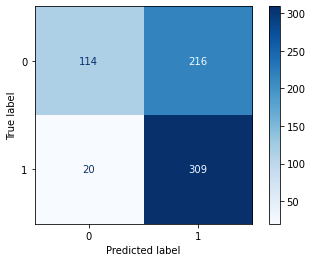

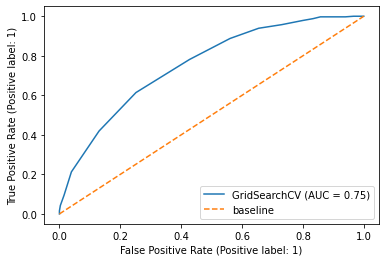

In [57]:
cm_roc(gs_cv_kn, X_test, y_test)

## Tiffy Diff with Logistic Regression <a class="anchor" id="TFLOG"></a>

In [58]:
#Using tfidf because it did slightly better than count vectorizer 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

tvec = TfidfVectorizer()
tvec.fit(X_train)
Z_train = tvec.transform(X_train)
Z_test = tvec.transform(X_test)

In [59]:
log = LogisticRegression()
log.fit(Z_train, y_train)

LogisticRegression()

In [60]:
cross_val_score(log, Z_train, y_train).mean()

0.7950751858684107

In [61]:
cross_val_score(log, Z_test, y_test).mean()

0.7785102937774695

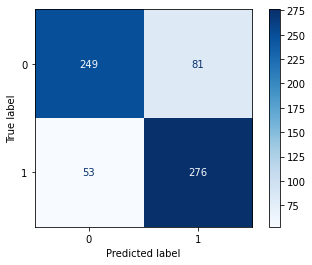

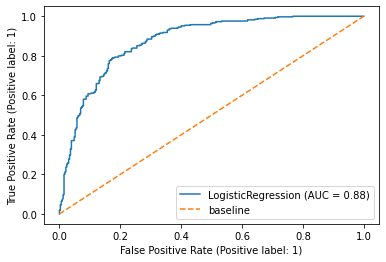

In [62]:
cm_roc(log, Z_test, y_test)

## Tiffy Diff with Linear Regression

In [63]:
# oooff
lr = LinearRegression()
lr.fit(Z_train, y_train)

LinearRegression()

In [64]:
cross_val_score(lr, Z_train, y_train).mean()

0.20482912132442577

In [65]:
cross_val_score(lr, Z_test, y_test).mean()

0.2628731182995604

## Tf-Idf with Random Forest <a class="anchor" id="TFRF"></a>

In [66]:
# Set up some scaffolding 
rf = RandomForestClassifier(random_state = 33, n_jobs = 6)


params = {
    'n_estimators':[65,70,75],
    'max_features': ['auto', None],
    'max_depth' : [4,5],
    #'min_samples_split': [3,4,5],
    'min_samples_leaf': [6,7],
    'ccp_alpha': [.03, .01]
}

gs_tf_rf = GridSearchCV(rf, param_grid=params, cv = 5)

gs_tf_rf.fit(Z_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=6, random_state=33),
             param_grid={'ccp_alpha': [0.03, 0.01], 'max_depth': [4, 5],
                         'max_features': ['auto', None],
                         'min_samples_leaf': [6, 7],
                         'n_estimators': [65, 70, 75]})

In [67]:
print(f'Training Score: {gs_tf_rf.score(Z_train, y_train)}')

# testing score
print(f'Testing Score: {gs_tf_rf.score(Z_test, y_test)}')

# best score
print(f'Best Score: {gs_tf_rf.best_score_}')

# best params
print(f'Best Params: {gs_tf_rf.best_params_}')

Training Score: 0.8025430067314884
Testing Score: 0.787556904400607
Best Score: 0.7980826206048409
Best Params: {'ccp_alpha': 0.01, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 7, 'n_estimators': 70}


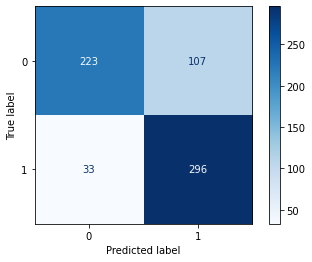

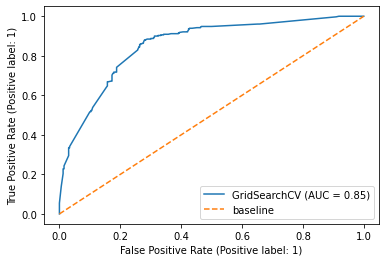

In [69]:
cm_roc(gs_tf_rf, Z_test, y_test)

## Tf-Idf with Decision Tree <a class="anchor" id="TFDT"></a>

In [70]:
dt = DecisionTreeClassifier(random_state=42)

params = {
    'max_depth' : [6, 7, 8, 9],
    'min_samples_split' : [12,15,17],
    'min_samples_leaf' : [6, 7, 8, 9],
    'ccp_alpha' : [0, .001, .01]
}

gs_tf_dt = GridSearchCV(dt, param_grid = params, cv = 5, verbose = 1, n_jobs = 4)

gs_tf_dt.fit(Z_train, y_train)



Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=4,
             param_grid={'ccp_alpha': [0, 0.001, 0.01],
                         'max_depth': [6, 7, 8, 9],
                         'min_samples_leaf': [6, 7, 8, 9],
                         'min_samples_split': [12, 15, 17]},
             verbose=1)

In [71]:
print(f'Training Score: {gs_tf_dt.score(Z_train, y_train)}')

# testing score
print(f'Testing Score: {gs_tf_dt.score(Z_test, y_test)}')

# best score
print(f'Best Score: {gs_tf_dt.best_score_}')

# best params
print(f'Best Params: {gs_tf_dt.best_params_}')

Training Score: 0.8399401645474944
Testing Score: 0.7587253414264037
Best Score: 0.7905975739281124
Best Params: {'ccp_alpha': 0, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 17}


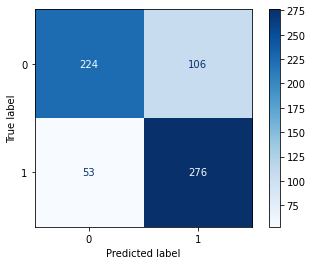

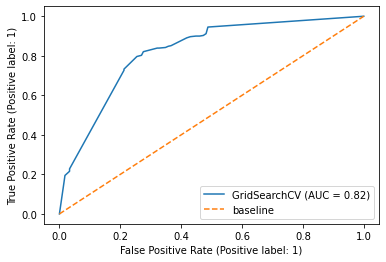

In [72]:
cm_roc(gs_tf_dt, Z_test, y_test)

## Tf Idf with SVM Model <a class="anchor" id="TFSVM"></a>

In [74]:
# Instantiate SVM.
svc = SVC()
p_grid = {
    "C" : np.linspace(0.00001, 5, 20),
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree" : [1, 2, 3]
}

# Fit on training data.
gs_tf_svm = GridSearchCV(svc, param_grid = p_grid, cv = 5, verbose = 1, n_jobs = 4)
gs_tf_svm.fit(Z_train, y_train)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=4,
             param_grid={'C': array([1.00000000e-05, 2.63167368e-01, 5.26324737e-01, 7.89482105e-01,
       1.05263947e+00, 1.31579684e+00, 1.57895421e+00, 1.84211158e+00,
       2.10526895e+00, 2.36842632e+00, 2.63158368e+00, 2.89474105e+00,
       3.15789842e+00, 3.42105579e+00, 3.68421316e+00, 3.94737053e+00,
       4.21052789e+00, 4.47368526e+00, 4.73684263e+00, 5.00000000e+00]),
                         'degree': [1, 2, 3],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=1)

In [75]:
print(f'Training Score: {gs_tf_svm.score(Z_train, y_train)}')

# testing score
print(f'Testing Score: {gs_tf_svm.score(Z_test, y_test)}')

# best score
print(f'Best Score: {gs_tf_svm.best_score_}')

# best params
print(f'Best Params: {gs_tf_svm.best_params_}')

Training Score: 0.9222139117427075
Testing Score: 0.7981790591805766
Best Score: 0.8115350215216054
Best Params: {'C': 0.5263247368421052, 'degree': 1, 'kernel': 'poly'}


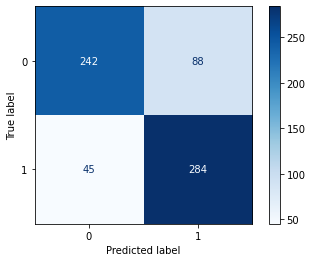

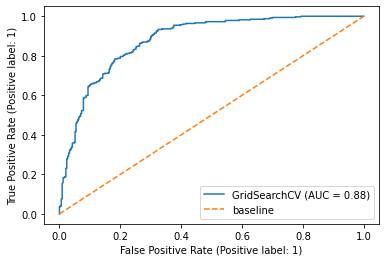

In [76]:
cm_roc(gs_tf_svm, Z_test, y_test)